In [1]:
import os
import rasterio
import numpy as np
import pandas as pd
from collections import defaultdict

In [2]:
pasta = "../input_data/01_lulc/lulc_data"
arquivos = [f for f in os.listdir(pasta) if f.startswith("land_use_30m_") and f.endswith(".tif")]
arquivos_lulc = [f for f in os.listdir(pasta) if f.startswith("land_use_30m_") and f.endswith(".geojson")]

## PARA AS UNIDADES HIDROGRÁFICAS

In [3]:
import os
import geopandas as gpd
import pandas as pd

gdf_zonas = gpd.read_file("../mapas/bh_ra.shp").to_crs(31983)  
zonas_nomes = gdf_zonas['ra'].tolist()  # Nomes das zonas

resultados = []
for arquivo in arquivos_lulc:
    ano = arquivo.split("_")[-1].replace(".geojson", "")
    caminho_lulc = os.path.join(pasta, arquivo)
    gdf_lulc = gpd.read_file(caminho_lulc)
    gdf_lulc = gdf_lulc.to_crs(gdf_zonas.crs)
    
    for idx_zona, zona in gdf_zonas.iterrows():
        lulc_na_zona = gpd.overlay(gdf_lulc, gpd.GeoDataFrame([zona]).set_crs(gdf_zonas.crs), how='intersection')
        for classe in lulc_na_zona['lucode'].unique(): 
            area_m2 = lulc_na_zona[lulc_na_zona['lucode'] == classe].area.sum()
            area_ha = area_m2 / 10_000 
            resultados.append({
                'ano': ano,
                'zona_id': zona['ra'],  
                'classe': classe,
                'area_ha': area_ha
            })


df_resultados_zonas = pd.DataFrame(resultados)

In [4]:
caminho_lulc

'../input_data/01_lulc/lulc_data/land_use_30m_2021.geojson'

In [ ]:
df_resultados_zonas.to_csv("df_resultados_ras.csv", index = False)

In [ ]:
df_resultados_zonas = pd.read_csv("df_resultados_ras.csv")

In [5]:
df_resultados_zonas.sample(5)

,ano,zona_id,classe,area_ha
6420,1996,Itapoã,24,181.158863
4059,2003,Guará,21,85.024387
1700,2005,Águas Claras,12,0.086245
6839,1987,Águas Claras,25,75.913584
9,2001,Plano Piloto,0,0.008323


In [6]:
df_resultados_zonas['area_percent'] = df_resultados_zonas.groupby(['zona_id', 'ano', 'zona_id'])['area_ha'].transform(
    lambda x: (x / x.sum()) * 100
).round(2)

In [7]:
df_resultados_zonas.zona_id.unique()

array(['Plano Piloto', 'Gama', 'Brazlândia', 'Sobradinho',
       'Candangolândia', 'Riacho Fundo II', 'Riacho Fundo',
       'Recanto das Emas', 'Lago Sul', 'Paranoá', 'Guará', 'Samambaia',
       'Santa Maria', 'Park Way', 'Sobradinho II', 'Jardim Botânico',
       'Vicente Pires', 'SIA', 'Águas Claras', 'Taguatinga', 'Arniqueira',
       'Sudoeste/ Octogonal', 'Varjão', 'Núcleo Bandeirante', 'Cruzeiro',
       'Lago Norte', 'SCIA', 'Itapoã'], dtype=object)

In [8]:
lulc_name = pd.read_excel('../input_data/01_lulc/codigos-da-legenda-colecao-9.xlsx').rename(columns = {"Nivel ": "Nivel"})

In [9]:
lulc_data_zonas = lulc_name[["Class_ID", "Nivel"]].merge(df_resultados_zonas, left_on = "Class_ID", right_on = "classe")[["Nivel", "zona_id", "ano", "area_ha", "area_percent"]]

In [10]:
print(sorted(lulc_data_zonas.Nivel.unique()))

['Agricultura', "Corpo D'Água", 'Floresta', 'Mosaico de Usos', 'Pastagem', 'Silvicultura', 'Vegetação Herbácea e Arbustiva', 'Área não Vegetada']


In [11]:
lulc_data_zonas['Nivel'] = lulc_data_zonas['Nivel'].replace(['Agricultura', 'Mosaico de Usos', 'Pastagem', 'Silvicultura'], 'Agropecuária')
lulc_data_zonas = lulc_data_zonas.groupby(['Nivel', "zona_id", 'ano'], as_index=False).agg({'area_ha': 'sum', 'area_percent': 'sum'})

In [13]:
lulc_data_zonas.zona_id.unique()

array(['Arniqueira', 'Brazlândia', 'Candangolândia', 'Cruzeiro', 'Gama',
       'Guará', 'Itapoã', 'Jardim Botânico', 'Lago Norte', 'Lago Sul',
       'Núcleo Bandeirante', 'Paranoá', 'Park Way', 'Plano Piloto',
       'Recanto das Emas', 'Riacho Fundo', 'Riacho Fundo II', 'SCIA',
       'SIA', 'Samambaia', 'Santa Maria', 'Sobradinho', 'Sobradinho II',
       'Sudoeste/ Octogonal', 'Taguatinga', 'Varjão', 'Vicente Pires',
       'Águas Claras'], dtype=object)

In [18]:
display(lulc_data_zonas[(lulc_data_zonas.ano == "1985") & (lulc_data_zonas.zona_id == 'Park Way')])
display(lulc_data_zonas[(lulc_data_zonas.ano == "2024") & (lulc_data_zonas.zona_id == 'Park Way')])
display(lulc_data_zonas[(lulc_data_zonas.ano == "1985") & (lulc_data_zonas.zona_id == 'Lago Sul')])
display(lulc_data_zonas[(lulc_data_zonas.ano == "2024") & (lulc_data_zonas.zona_id == 'Lago Sul')])

,Nivel,zona_id,ano,area_ha,area_percent
452,Agropecuária,Park Way,1985,1331.914302,11.44
1309,Corpo D'Água,Park Way,1985,25.743093,0.22
2059,Floresta,Park Way,1985,7853.205933,67.39
3088,Vegetação Herbácea e Arbustiva,Park Way,1985,771.026545,6.61
4079,Área não Vegetada,Park Way,1985,1672.212331,14.35


,Nivel,zona_id,ano,area_ha,area_percent
491,Agropecuária,Park Way,2024,2416.196805,20.73
1348,Corpo D'Água,Park Way,2024,16.720786,0.14
2098,Floresta,Park Way,2024,6238.780183,53.53
3127,Vegetação Herbácea e Arbustiva,Park Way,2024,459.414476,3.95
4118,Área não Vegetada,Park Way,2024,2522.989945,21.65


,Nivel,zona_id,ano,area_ha,area_percent
332,Agropecuária,Lago Sul,1985,639.466664,8.41
1199,Corpo D'Água,Lago Sul,1985,68.324453,0.90
1939,Floresta,Lago Sul,1985,4422.293891,58.17
2968,Vegetação Herbácea e Arbustiva,Lago Sul,1985,261.298109,3.44
3959,Área não Vegetada,Lago Sul,1985,2210.643512,29.08


,Nivel,zona_id,ano,area_ha,area_percent
371,Agropecuária,Lago Sul,2024,709.218524,9.33
1238,Corpo D'Água,Lago Sul,2024,29.975373,0.39
1978,Floresta,Lago Sul,2024,3548.170201,46.67
3007,Vegetação Herbácea e Arbustiva,Lago Sul,2024,134.427939,1.77
3998,Área não Vegetada,Lago Sul,2024,3180.234667,41.83


In [29]:
lulc_data_zonas = lulc_name[lulc_name.Level == 1][["Nivel", "Color"]].merge(lulc_data_zonas, on = "Nivel")

In [ ]:
lulc_data_zonas

In [36]:
lulc_data_zonas[(lulc_data_zonas.Nivel == "Floresta" ) & (lulc_data_zonas.zona_id == "Plano Piloto")]

,Nivel,Color,zona_id,ano,area_ha,area_percent
484,Floresta,#32a65e,Plano Piloto,1985,28121.280161,66.25
485,Floresta,#32a65e,Plano Piloto,1986,27995.365616,65.95
486,Floresta,#32a65e,Plano Piloto,1987,28216.242911,66.47
487,Floresta,#32a65e,Plano Piloto,1988,28166.722000,66.36
488,Floresta,#32a65e,Plano Piloto,1989,28083.449140,66.16
489,Floresta,#32a65e,Plano Piloto,1990,27975.980286,65.91
490,Floresta,#32a65e,Plano Piloto,1991,27808.602482,65.51
491,Floresta,#32a65e,Plano Piloto,1992,27719.777586,65.30
492,Floresta,#32a65e,Plano Piloto,1993,27715.025558,65.28
493,Floresta,#32a65e,Plano Piloto,1994,27699.898558,65.25


In [31]:
lulc_data_zonas.zona_id.unique()

array(['Arniqueira', 'Brazlândia', 'Candangolândia', 'Cruzeiro', 'Gama',
       'Guará', 'Itapoã', 'Jardim Botânico', 'Lago Norte', 'Lago Sul',
       'Núcleo Bandeirante', 'Paranoá', 'Park Way', 'Plano Piloto',
       'Recanto das Emas', 'Riacho Fundo', 'Riacho Fundo II', 'SCIA',
       'SIA', 'Samambaia', 'Santa Maria', 'Sobradinho', 'Sobradinho II',
       'Sudoeste/ Octogonal', 'Taguatinga', 'Varjão', 'Vicente Pires',
       'Águas Claras'], dtype=object)

In [32]:
lulc_data_zonas[(lulc_data_zonas.ano == 1985) & (lulc_data_zonas.zona_id == 'UH 13  Riacho Fundo')]

,Nivel,Color,zona_id,ano,area_ha,area_percent


IndexError: index 5 is out of bounds for axis 0 with size 5

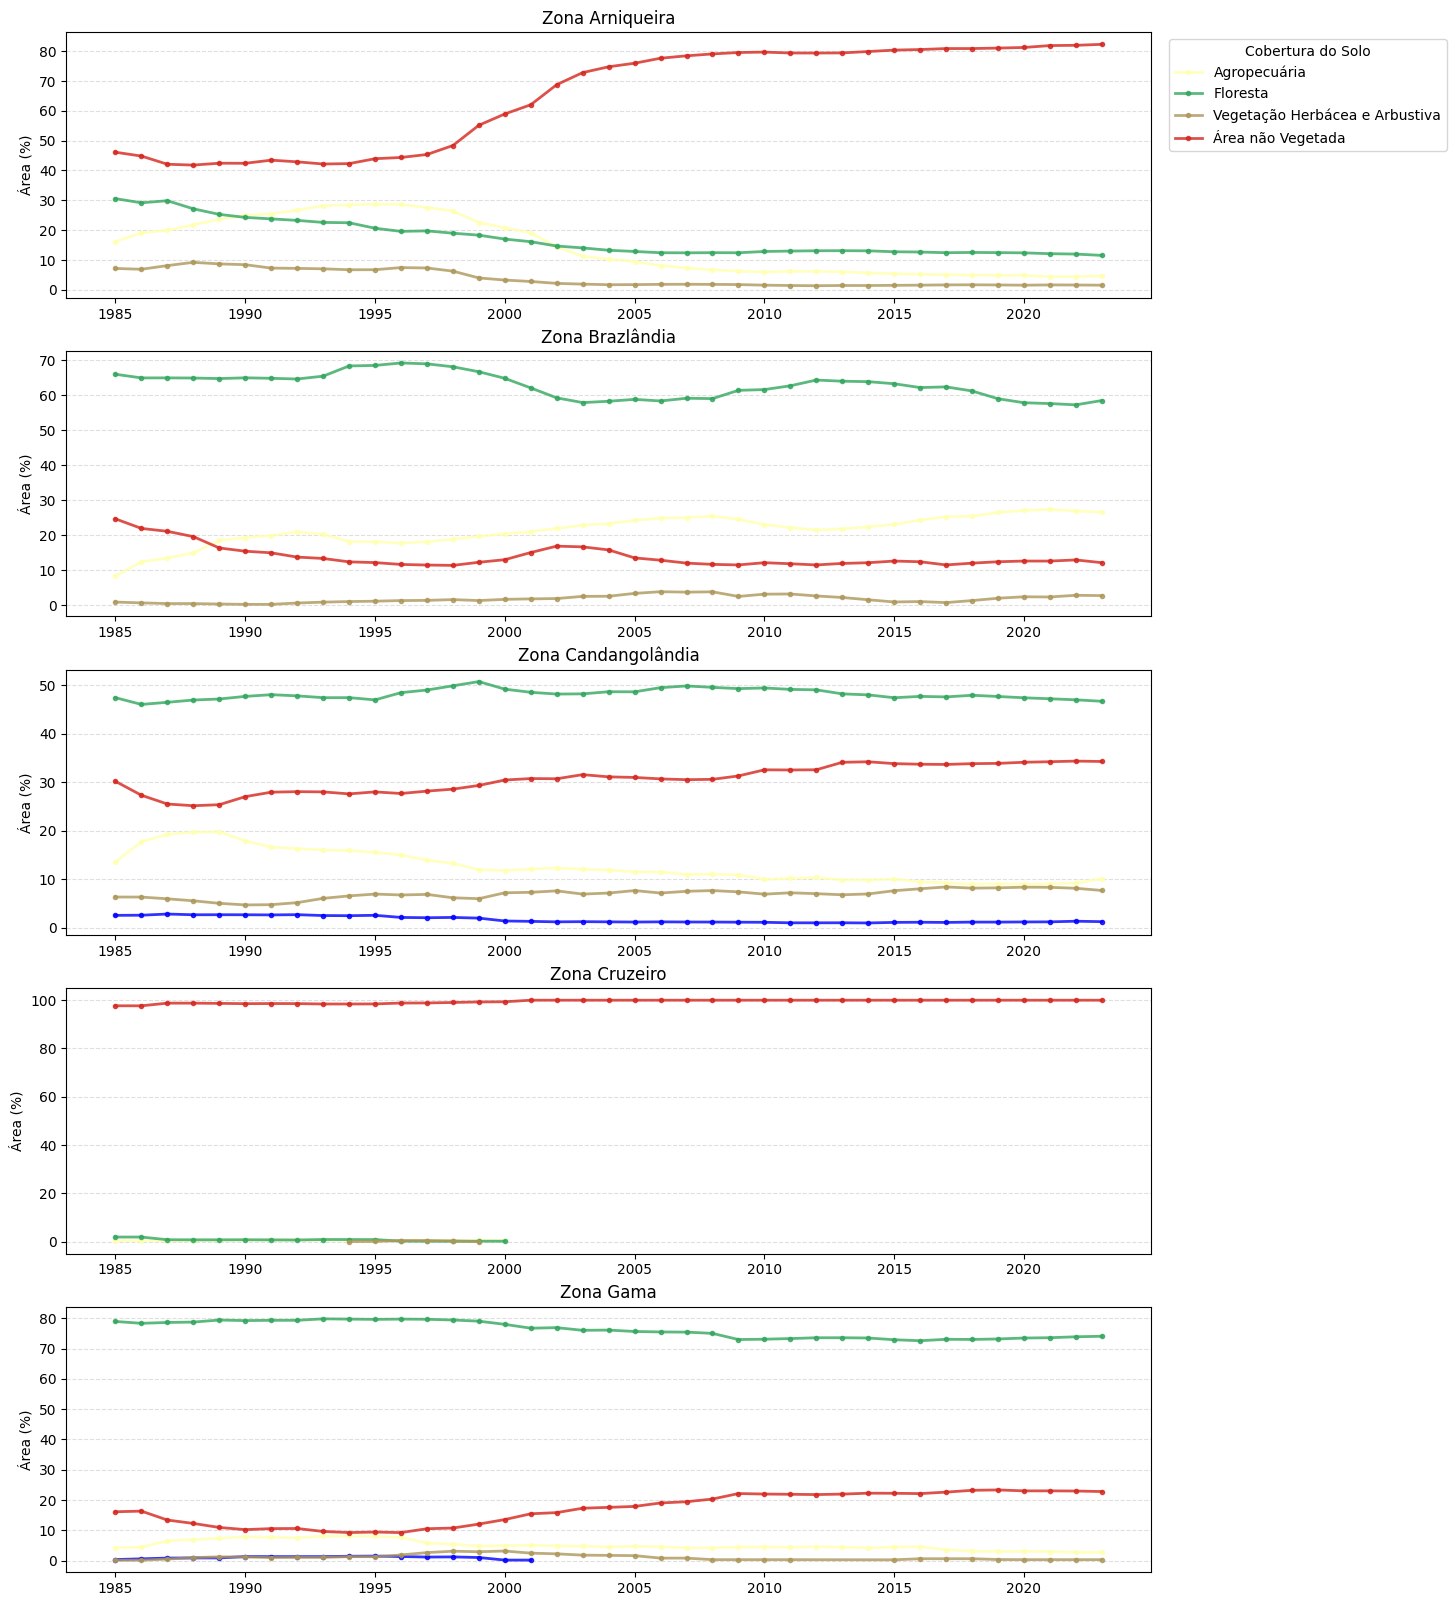

In [34]:
import matplotlib.pyplot as plt 


fig, axes = plt.subplots(5, 1, figsize=(14, 20))

# Para cada zona (1 a 5)
for i, zona in enumerate(lulc_data_zonas['zona_id'].unique(), start=1):
    ax = axes[i-1]  # Índice começa em 0
    
    # Filtrar dados para a zona atual
    df_zona = lulc_data_zonas[lulc_data_zonas['zona_id'] == zona]
    df_plot = df_zona.groupby(['ano', 'Nivel', 'Color'])['area_percent'].mean().reset_index()
    
    # Plotar cada nível
    for nivel in df_plot['Nivel'].unique():
        subset = df_plot[df_plot['Nivel'] == nivel]
        cor = subset['Color'].iloc[0]
        ax.plot(subset['ano'], subset['area_percent'],
                marker='o',
                markersize=3,
                label=f'{nivel}',
                color=cor,
                alpha=0.8,
                linewidth=2)
    
    # Configurar cada subplot
    ax.set_title(f'Zona {zona}', fontsize=12)
    ax.set_ylabel('Área (%)', fontsize=10)
    ax.grid(True, axis='y', linestyle='--', alpha=0.4)
    ax.grid(False, axis='x')
    ax.set_xticks(df_plot['ano'].unique()[::5])  # Anos de 5 em 5
    
    # Adicionar legenda apenas no último subplot
    if i == 1:
        ax.legend(title='Cobertura do Solo', bbox_to_anchor=(1.01, 1), fontsize=10)

# Configurações gerais
plt.suptitle('Evolução da Área por Cobertura do Solo por Zona (1985-2023)', fontsize=14, y=1.02)
plt.xlabel('Ano', fontsize=12)
plt.tight_layout()
plt.show()

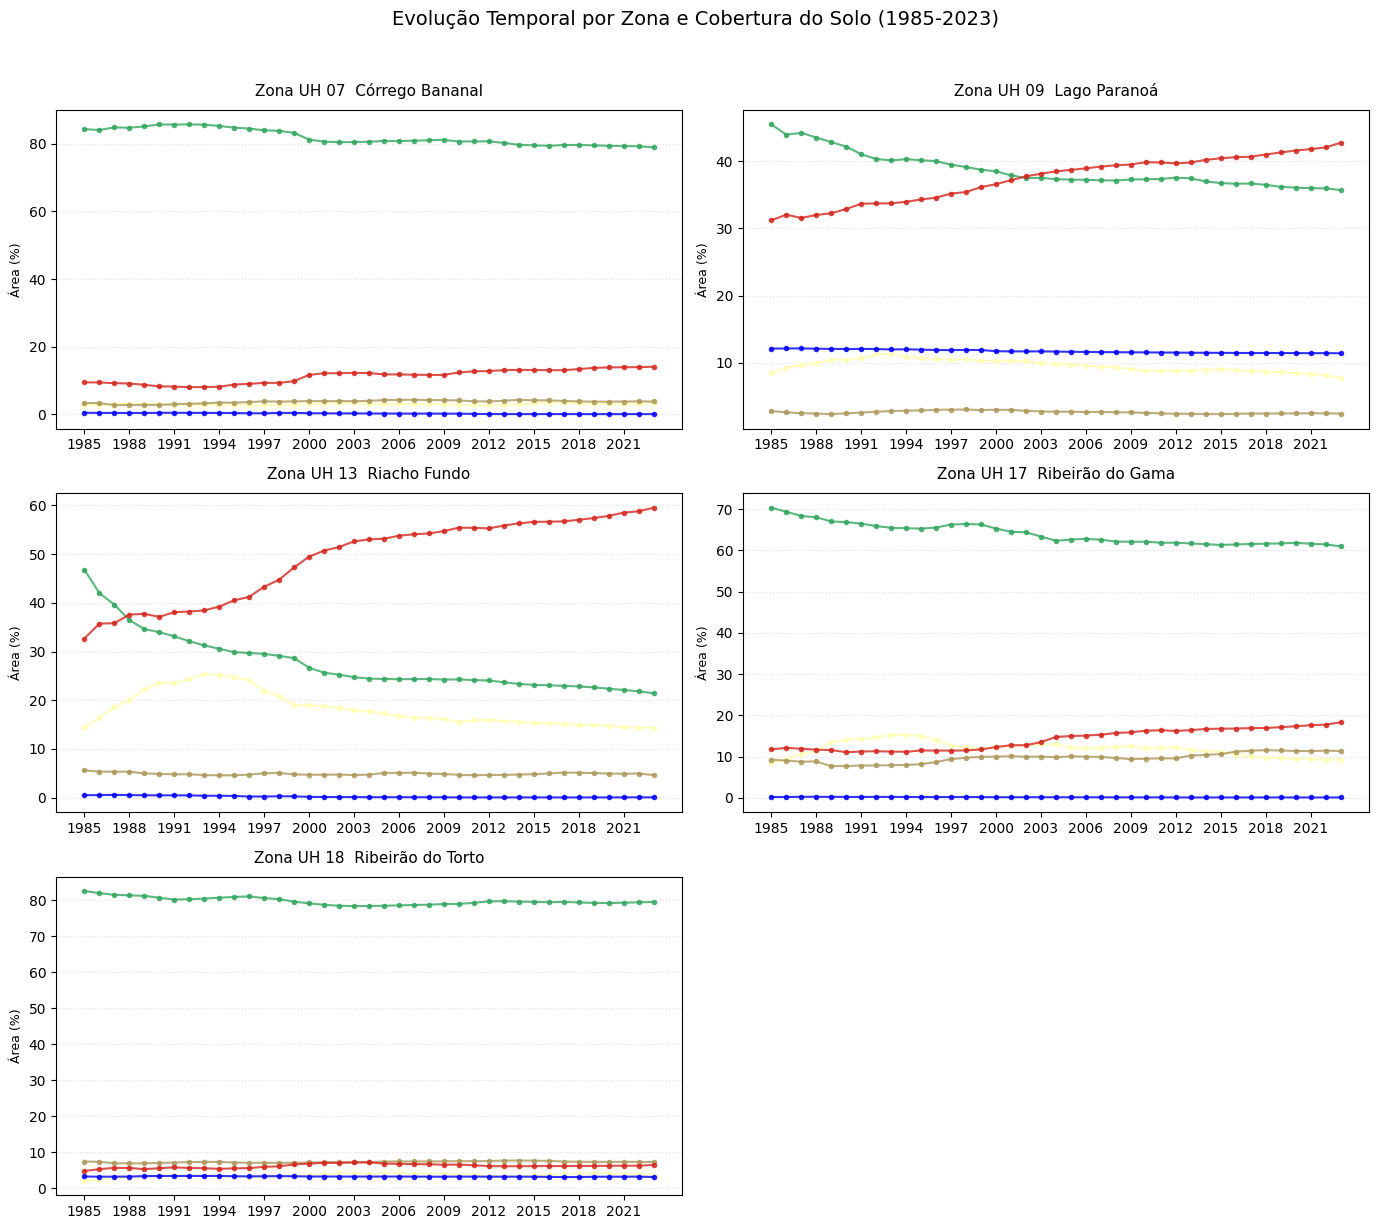

In [37]:

n_cols = 2
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 12))

# Achatar o array de eixos para facilitar iteração
axes = axes.flatten()

# Para cada zona
for i, zona in enumerate(sorted(lulc_data_zonas['zona_id'].unique())):
    ax = axes[i]
    
    # Filtrar dados para a zona atual
    df_zona = lulc_data_zonas[lulc_data_zonas['zona_id'] == zona]
    df_plot = df_zona.groupby(['ano', 'Nivel', 'Color'])['area_percent'].mean().reset_index()
    
    # Plotar cada nível
    for nivel in df_plot['Nivel'].unique():
        subset = df_plot[df_plot['Nivel'] == nivel]
        cor = subset['Color'].iloc[0]
        ax.plot(subset['ano'], subset['area_percent'],
                marker='o',
                markersize=3,
                label=f'Nível {nivel}',
                color=cor,
                alpha=0.8,
                linewidth=1.5)
    
    # Configurações do subplot
    ax.set_title(f'Zona {zona}', fontsize=11, pad=10)
    ax.set_ylabel('Área (%)', fontsize=9)
    ax.grid(True, axis='y', linestyle=':', alpha=0.4)
    ax.grid(False, axis='x')
    ax.set_xticks(df_plot['ano'].unique()[::3])  # Mostrar de 3 em 3 anos para melhor legibilidade
    
    # Adicionar legenda apenas no último subplot
   # if i == 4:
    #    ax.legend(title='Cobertura', bbox_to_anchor=(1.1, 1), fontsize=8, title_fontsize=9)

# Ajustes finais
plt.suptitle('Evolução Temporal por Zona e Cobertura do Solo (1985-2023)', 
             fontsize=14, 
             y=1.02)
plt.tight_layout()

# Ocultar eixos vazios se tiver menos zonas que subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')
plt.savefig('./graficos/lulc_paranoa_uh.png', dpi=300, bbox_inches='tight')  # PNG
plt.show()

In [38]:
lulc_data_zonas.zona_id.unique()

array(['UH 07  Córrego Bananal', 'UH 09  Lago Paranoá',
       'UH 13  Riacho Fundo', 'UH 17  Ribeirão do Gama',
       'UH 18  Ribeirão do Torto'], dtype=object)

Floresta
        Nivel   ano  area_percent  diferenca  diferenca_abs
117  Floresta  1985         70.32        NaN            NaN
        Nivel   ano  area_percent  diferenca  diferenca_abs
155  Floresta  2023         60.96      -0.46           0.46


,Nivel,ano,area_percent,diferenca,diferenca_abs
117,Floresta,1985,70.32,NaN,NaN
118,Floresta,1986,69.33,-0.99,0.99
119,Floresta,1987,68.32,-1.01,1.01
120,Floresta,1988,68.00,-0.32,0.32
121,Floresta,1989,66.98,-1.02,1.02
122,Floresta,1990,66.84,-0.14,0.14
123,Floresta,1991,66.46,-0.38,0.38
124,Floresta,1992,65.88,-0.58,0.58
125,Floresta,1993,65.44,-0.44,0.44
126,Floresta,1994,65.36,-0.08,0.08


      ano  area_percent  diferenca
136  2004         62.31      -1.03
121  1989         66.98      -1.02
119  1987         68.32      -1.01
132  2000         65.25      -1.01
135  2003         63.34      -1.01
Vegetação Herbácea e Arbustiva
                              Nivel   ano  area_percent  diferenca  \
345  Vegetação Herbácea e Arbustiva  2018         11.57       0.13   

     diferenca_abs  
345           0.13  
                              Nivel   ano  area_percent  diferenca  \
316  Vegetação Herbácea e Arbustiva  1989          7.68      -1.14   

     diferenca_abs  
316           1.14  


,Nivel,ano,area_percent,diferenca,diferenca_abs
312,Vegetação Herbácea e Arbustiva,1985,9.26,NaN,NaN
313,Vegetação Herbácea e Arbustiva,1986,9.02,-0.24,0.24
314,Vegetação Herbácea e Arbustiva,1987,8.78,-0.24,0.24
315,Vegetação Herbácea e Arbustiva,1988,8.82,0.04,0.04
316,Vegetação Herbácea e Arbustiva,1989,7.68,-1.14,1.14
317,Vegetação Herbácea e Arbustiva,1990,7.72,0.04,0.04
318,Vegetação Herbácea e Arbustiva,1991,7.84,0.12,0.12
319,Vegetação Herbácea e Arbustiva,1992,7.85,0.01,0.01
320,Vegetação Herbácea e Arbustiva,1993,7.91,0.06,0.06
321,Vegetação Herbácea e Arbustiva,1994,7.98,0.07,0.07


      ano  area_percent  diferenca
316  1989          7.68      -1.14
324  1997          9.40       0.70
340  2013         10.26       0.69
343  2016         11.20       0.59
323  1996          8.70       0.54
Agropecuária
            Nivel   ano  area_percent  diferenca  diferenca_abs
516  Agropecuária  1994         15.26       0.05           0.05
            Nivel   ano  area_percent  diferenca  diferenca_abs
507  Agropecuária  1985          8.47        NaN            NaN


,Nivel,ano,area_percent,diferenca,diferenca_abs
507,Agropecuária,1985,8.47,NaN,NaN
508,Agropecuária,1986,9.31,0.84,0.84
509,Agropecuária,1987,10.73,1.42,1.42
510,Agropecuária,1988,11.25,0.52,0.52
511,Agropecuária,1989,13.53,2.28,2.28
512,Agropecuária,1990,14.13,0.60,0.60
513,Agropecuária,1991,14.24,0.11,0.11
514,Agropecuária,1992,14.73,0.49,0.49
515,Agropecuária,1993,15.21,0.48,0.48
516,Agropecuária,1994,15.26,0.05,0.05


      ano  area_percent  diferenca
511  1989         13.53       2.28
519  1997         12.69      -1.44
509  1987         10.73       1.42
508  1986          9.31       0.84
518  1996         14.13      -0.79
Área não Vegetada
                 Nivel   ano  area_percent  diferenca  diferenca_abs
740  Área não Vegetada  2023         18.31       0.57           0.57
                 Nivel   ano  area_percent  diferenca  diferenca_abs
707  Área não Vegetada  1990         11.08      -0.49           0.49


,Nivel,ano,area_percent,diferenca,diferenca_abs
702,Área não Vegetada,1985,11.76,NaN,NaN
703,Área não Vegetada,1986,12.12,0.36,0.36
704,Área não Vegetada,1987,11.90,-0.22,0.22
705,Área não Vegetada,1988,11.68,-0.22,0.22
706,Área não Vegetada,1989,11.57,-0.11,0.11
707,Área não Vegetada,1990,11.08,-0.49,0.49
708,Área não Vegetada,1991,11.23,0.15,0.15
709,Área não Vegetada,1992,11.30,0.07,0.07
710,Área não Vegetada,1993,11.22,-0.08,0.08
711,Área não Vegetada,1994,11.17,-0.05,0.05


      ano  area_percent  diferenca
721  2004         14.76       1.25
720  2003         13.51       0.74
717  2000         12.31       0.57
740  2023         18.31       0.57
707  1990         11.08      -0.49
Corpo D'Água
            Nivel   ano  area_percent  diferenca  diferenca_abs
899  Corpo D'Água  1987          0.26       0.04           0.04
            Nivel   ano  area_percent  diferenca  diferenca_abs
928  Corpo D'Água  2016           0.1        0.0            0.0


,Nivel,ano,area_percent,diferenca,diferenca_abs
897,Corpo D'Água,1985,0.20,NaN,NaN
898,Corpo D'Água,1986,0.22,0.02,0.02
899,Corpo D'Água,1987,0.26,0.04,0.04
900,Corpo D'Água,1988,0.26,0.00,0.00
901,Corpo D'Água,1989,0.24,-0.02,0.02
902,Corpo D'Água,1990,0.23,-0.01,0.01
903,Corpo D'Água,1991,0.23,0.00,0.00
904,Corpo D'Água,1992,0.24,0.01,0.01
905,Corpo D'Água,1993,0.23,-0.01,0.01
906,Corpo D'Água,1994,0.22,-0.01,0.01


      ano  area_percent  diferenca
899  1987          0.26       0.04
912  2000          0.16      -0.03
901  1989          0.24      -0.02
898  1986          0.22       0.02
907  1995          0.20      -0.02
Matriz de Correlação:


Nivel,Agropecuária,Corpo D'Água,Floresta,Vegetação Herbácea e Arbustiva,Área não Vegetada
Nivel,,,,,
Agropecuária,1.000000,0.523974,0.232759,-0.765731,-0.618109
Corpo D'Água,0.523974,1.000000,0.908670,-0.854904,-0.938320
Floresta,0.232759,0.908670,1.000000,-0.700467,-0.891445
Vegetação Herbácea e Arbustiva,-0.765731,-0.854904,-0.700467,1.000000,0.827907
Área não Vegetada,-0.618109,-0.938320,-0.891445,0.827907,1.000000


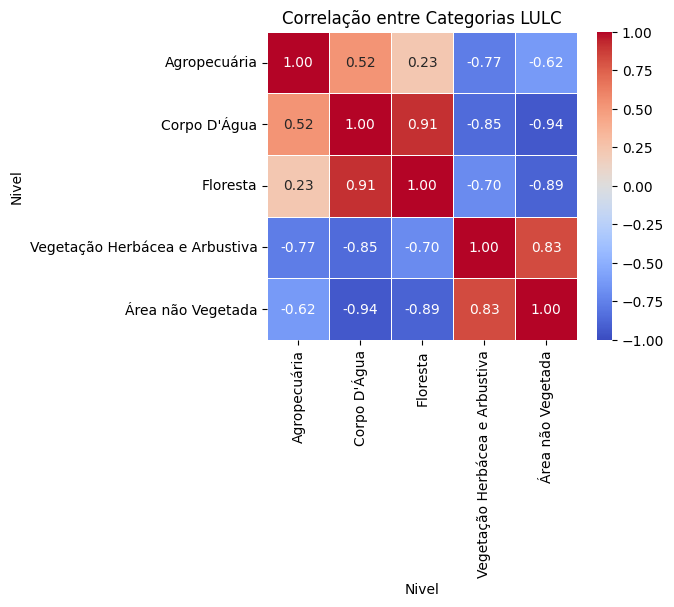

In [39]:
lulc_data = lulc_data_zonas[lulc_data_zonas.zona_id == 'UH 17  Ribeirão do Gama']
for nivel in lulc_data.Nivel.unique():
    print(nivel)
    filt = lulc_data[lulc_data.Nivel == nivel][["Nivel", "ano", "area_percent"]].sort_values("ano")
    filt["diferenca"] = filt["area_percent"].diff()
    filt["diferenca_abs"] = filt["diferenca"].abs()
    print(filt.sort_values("area_percent", ascending = False).head(1))
    print(filt.sort_values("area_percent").head(1))
    display(filt) #.sort_values("diferenca"))
    maiores_diferencas = filt.nlargest(5, "diferenca_abs")
    print(maiores_diferencas[["ano", "area_percent", "diferenca"]])

    lulc_pivot = lulc_data.pivot(index='ano', columns='Nivel', values='area_percent')
    correlacao = lulc_pivot.corr()
    
print("Matriz de Correlação:")
display(correlacao)
plt.figure(figsize=(5, 4))
sns.heatmap(
    correlacao,
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    fmt=".2f"
)

plt.title("Correlação entre Categorias LULC")
plt.show()

In [43]:
lulc_data_zonas[lulc_data_zonas.ano.isin(["1985", "2023"])][["Nivel", "zona_id", "ano", "area_ha"]]#.to_excel("./graficos/lulc_uh.xlsx")

,Nivel,zona_id,ano,area_ha
0,Floresta,Arniqueira,1985,408.063755
38,Floresta,Arniqueira,2023,153.952024
39,Floresta,Brazlândia,1985,227.023576
77,Floresta,Brazlândia,2023,201.221180
78,Floresta,Candangolândia,1985,313.046213
...,...,...,...,...
4635,Corpo D'Água,Sobradinho,1985,0.661408
4650,Corpo D'Água,Sobradinho II,1985,1.966206
4668,Corpo D'Água,Varjão,1985,0.059405
4688,Corpo D'Água,Vicente Pires,1985,28.216596


In [45]:
# Filtrar e pivotar os dados
filtered_data = lulc_data_zonas[lulc_data_zonas.ano.isin(["1985", "2023"])][["Nivel", "zona_id", "ano", "area_ha"]]
pivot_df = filtered_data.pivot_table(index=["zona_id", "Nivel"], columns="ano", values="area_ha").fillna(0).reset_index()

# Função para calcular a diferença conforme as regras
def calcular_diferenca(row):
    if row["Nivel"] == "Floresta":
        return row["1985"] - row["2023"]
    elif row["Nivel"] == "Área não Vegetada":
        return row["2023"] - row["1985"]
    else:
        return None

# Aplicar a função e filtrar apenas os níveis desejados
resultado_df = pivot_df[pivot_df["Nivel"].isin(["Floresta", "Área não Vegetada"])].copy()
resultado_df["diferenca_area_ha"] = resultado_df.apply(calcular_diferenca, axis=1)
resultado_df.sample(5)

ano,zona_id,Nivel,1985,2023,diferenca_area_ha
123,Vicente Pires,Área não Vegetada,934.338646,3287.033384,2352.694738
85,SIA,Floresta,1392.195052,1324.104000,68.091052
113,Taguatinga,Área não Vegetada,322.763192,388.587248,65.824056
3,Arniqueira,Área não Vegetada,615.807557,1098.774613,482.967056
105,Sobradinho II,Área não Vegetada,242.119277,355.037636,112.918358


In [54]:
resultado_df[resultado_df.Nivel == "Área não Vegetada"].sort_values("diferenca_area_ha", ascending = False)

ano,zona_id,Nivel,1985,2023,diferenca_area_ha
123,Vicente Pires,Área não Vegetada,934.338646,3287.033384,2352.694738
64,Plano Piloto,Área não Vegetada,6247.424535,7662.126773,1414.702237
59,Park Way,Área não Vegetada,2169.722315,3374.657355,1204.935040
39,Lago Norte,Área não Vegetada,1841.301545,2797.973817,956.672272
44,Lago Sul,Área não Vegetada,2649.724213,3599.058737,949.334524
78,Riacho Fundo II,Área não Vegetada,151.145154,951.451815,800.306660
3,Arniqueira,Área não Vegetada,615.807557,1098.774613,482.967056
29,Itapoã,Área não Vegetada,68.595421,531.163068,462.567647
54,Paranoá,Área não Vegetada,533.339690,896.336873,362.997183
128,Águas Claras,Área não Vegetada,343.906119,697.415500,353.509380


In [52]:
resultado_df[resultado_df.Nivel == "Floresta"].sort_values("diferenca_area_ha", ascending = False)

ano,zona_id,Nivel,1985,2023,diferenca_area_ha
121,Vicente Pires,Floresta,2791.593752,613.736207,2177.857545
57,Park Way,Floresta,6854.405146,5238.872301,1615.532844
76,Riacho Fundo II,Floresta,2341.143407,1109.306112,1231.837295
62,Plano Piloto,Floresta,28121.280161,26945.617875,1175.662286
37,Lago Norte,Floresta,4970.881868,4029.469908,941.411961
42,Lago Sul,Floresta,4024.140470,3141.218652,882.921818
27,Itapoã,Floresta,611.964755,133.586199,478.378557
103,Sobradinho II,Floresta,1024.145274,562.010835,462.134439
80,SCIA,Floresta,464.589419,81.985127,382.604293
71,Riacho Fundo,Floresta,882.614079,558.721019,323.893060
